In [ ]:
# === CELL 1: GPU Check and Setup ===

# Check GPU availability
import tensorflow as tf
import os

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Check GPU details (will only work in Colab)
print("\nGPU Details:")
# This command is for Colab environment
# !nvidia-smi

TensorFlow version: 2.19.0
GPU Available: []

GPU Details:


In [ ]:
# === CELL 2: Install Required Libraries and Imports ===

# Install additional libraries (will only work in Colab)
# !pip install -q kaggle opencv-python-headless scikit-learn matplotlib seaborn pillow

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import zipfile
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Sklearn for metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [ ]:
!export KAGGLE_API_TOKEN=KGAT_0de04b77b71aa91707632f5cb5e93643


In [ ]:

# 1) تثبيت Kaggle
!pip install -q kaggle

# 2) إنشاء ملف kaggle.json بالطريقة التقليدية
import json
os.makedirs('/root/.kaggle', exist_ok=True)
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump({"username":"YOUR_KAGGLE_USERNAME","key":"YOUR_API_KEY"}, f)
os.chmod('/root/.kaggle/kaggle.json', 0o600)

# 3) تنزيل وفك الضغط
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset --unzip -p brain_tumor_data
# === CELL 6: Set Paths and Count Images ===

# Set correct paths (adjust based on actual structure)
# The dataset typically has Training and Testing folders
train_dir = 'brain_tumor_data/Training'
test_dir = 'brain_tumor_data/Testing'

# Class names
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Count images per class
print("\n=== Training Set ===")
train_counts = {}
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.exists(class_path):
        count = len(os.listdir(class_path))
        train_counts[class_name] = count
        print(f"{class_name}: {count} images")

print(f"\nTotal training images: {sum(train_counts.values())}")

print("\n=== Testing Set ===")
test_counts = {}
for class_name in class_names:
    class_path = os.path.join(test_dir, class_name)
    if os.path.exists(class_path):
        count = len(os.listdir(class_path))
        test_counts[class_name] = count
        print(f"{class_name}: {count} images")

print(f"\nTotal testing images: {sum(test_counts.values())}")


Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 57% 85.0M/149M [00:00<00:00, 885MB/s]
100% 149M/149M [00:00<00:00, 428MB/s] 

=== Training Set ===
glioma: 1321 images
meningioma: 1339 images
notumor: 1595 images
pituitary: 1457 images

Total training images: 5712

=== Testing Set ===
glioma: 300 images
meningioma: 306 images
notumor: 405 images
pituitary: 300 images

Total testing images: 1311


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # 4 classes
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()013.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 424,260 (1.62 MB)

 Trainable params: 423,044 (1.61 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [ ]:
EPOCHS = 10

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1025s 7s/step - accuracy: 0.5989 - loss: 1.0625 - val_accuracy: 0.2550 - val_loss: 2.5256
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1019s 7s/step - accuracy: 0.6822 - loss: 0.8278 - val_accuracy: 0.2550 - val_loss: 4.4091
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1011s 7s/step - accuracy: 0.7020 - loss: 0.8024 - val_accuracy: 0.2550 - val_loss: 6.2811
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 991s 7s/step - accuracy: 0.7569 - loss: 0.6390 - val_accuracy: 0.2568 - val_loss: 8.0083
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 992s 7s/step - accuracy: 0.7792 - loss: 0.6144 - val_accuracy: 0.2761 - val_loss: 7.6979
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 966s 7s/step - accuracy: 0.7892 - loss: 0.5426 - val_accuracy: 0.3103 - val_loss: 8.9194
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 977s 7s/step - accuracy: 0.7820 - loss: 0.5779 - val_accuracy: 0.3059 - val_loss: 7.4286
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 1007s 7s/step - accuracy: 0.8003 - loss: 0.5257 - val_

In [ ]:
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {train_acc*100:.2f}%")
print(f"Final Validation Accuracy: {val_acc*100:.2f}%")


Final Training Accuracy: 81.91%
Final Validation Accuracy: 33.57%


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy*100:.2f}%")


41/41 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.1227 - loss: 12.9799
Test Accuracy: 40.66%


In [ ]:
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(
    y_true,
    y_pred_classes,
    target_names=class_names
))


In [ ]:
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


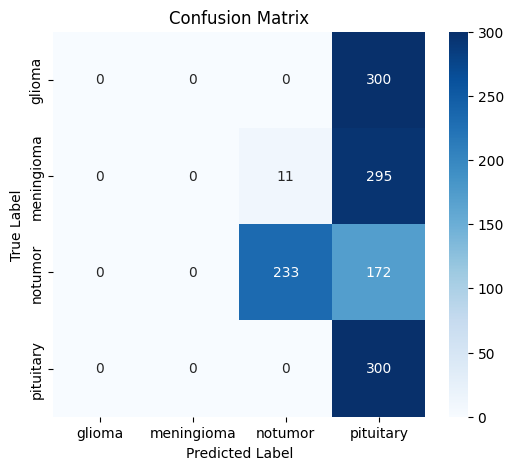

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
